In [1]:
# Created by Dave Slinger (@dslgr on github) in March 2020
import numpy as np
import pandas as pd
import geopandas
import matplotlib
import subprocess # subprocess will utilize ogr2ogr from the gdal library (I installed using conda)
import xml.etree.ElementTree as ET

data on the number of indoor and outdoor OD fatalities
this csv was transcribed from these two Philadelphia Dept of Public Health Opioid Reports
- https://www.phila.gov/media/20200213165844/Substance-Abuse-Data-Report-02.13.pdf
- https://www.phila.gov/media/20200226121229/Substance-Abuse-Data-Report-02.26.20.pdf

Thank you Josephine Dru for the work of transcribing the data over as a spreadsheet!

In [2]:
tract_df = pd.read_csv(r"fatal-overdoses_philadelphia-census-tracts_2017-01_2019-06.csv")
tract_df.head(3)

,TractNum,TotalMIN,TotalMid,TotalMAX,IndoorsMin,IndoorsMax,OutdoorsMin,OutdoorsMax,NAMELSAD10,OBJECTID,INTPTLAT10,INTPTLON10,LOGRECNO,TRACTCE10,GEOID10,ALAND10,AWATER10,Unnamed: 17,UAID
0,94.0,6,9.0,12,6,12,0,0,Census Tract 94,1,39.963271,-75.232244,10429,9400,42101009400,366717,0,NaN,489382
1,95.0,7,11.5,16,6,12,1,4,Census Tract 95,2,39.965871,-75.237914,10430,9500,42101009500,319070,0,NaN,489383
2,96.0,7,11.5,16,6,12,1,4,Census Tract 96,3,39.965540,-75.243507,10431,9600,42101009600,405273,0,NaN,489384


geojson data of the shape of every census tract

pulled from https://www.pasda.psu.edu/uci/DataSummary.aspx?dataset=1571

In [3]:
tract_geo = geopandas.read_file(r"Philadelphia_Census_Tracts_2010_201302.geojson")
tract_geo.head(3)

,NAME10,AWATER10,TRACTCE10,OBJECTID,GEOID10,ALAND10,STATEFP10,FUNCSTAT10,NAMELSAD10,COUNTYFP10,INTPTLAT10,Shape_Leng,LOGRECNO,MTFCC10,INTPTLON10,geometry
0,50,3340294.0,005000,46.0,42101005000,4504459.0,42,S,Census Tract 50,101,+39.8898768,48033.335048,10389,G5020,-075.1691412,"POLYGON ((-75.17214 39.88129, -75.17505 39.881..."
1,54,530013.0,005400,47.0,42101005400,1846253.0,42,S,Census Tract 54,101,+39.8904539,24624.823144,10390,G5020,-075.2513923,"POLYGON ((-75.24623 39.88951, -75.24799 39.887..."
2,55,12010.0,005500,48.0,42101005500,1168442.0,42,S,Census Tract 55,101,+39.9074191,20389.059940,10391,G5020,-075.2489174,"POLYGON ((-75.25129 39.90440, -75.25297 39.905..."


In [4]:
# converting this column to a float so that the census tract columns can be joined
# against the two dataframes
tract_geo['TRACT_FLOAT'] = tract_geo['NAME10'].astype(float)
tract_geo['TRACT_FLOAT']

0       50.0
1       54.0
2       55.0
3       56.0
4       60.0
       ...  
379    237.0
380    238.0
381    239.0
382    240.0
383    257.0
Name: TRACT_FLOAT, Length: 384, dtype: float64

In [5]:
# joining the dataframes
tracts_merged = pd.merge(tract_geo, tract_df, left_on='TRACT_FLOAT', right_on='TractNum')
tracts_merged

,NAME10,AWATER10_x,TRACTCE10_x,OBJECTID_x,GEOID10_x,ALAND10_x,STATEFP10,FUNCSTAT10,NAMELSAD10_x,COUNTYFP10,...,OBJECTID_y,INTPTLAT10_y,INTPTLON10_y,LOGRECNO_y,TRACTCE10_y,GEOID10_y,ALAND10_y,AWATER10_y,Unnamed: 17,UAID
0,50,3340294.0,005000,46.0,42101005000,4504459.0,42,S,Census Tract 50,101,...,46,39.889877,-75.169141,10389,5000,42101005000,4504459,3340294,NaN,489437
1,54,530013.0,005400,47.0,42101005400,1846253.0,42,S,Census Tract 54,101,...,47,39.890454,-75.251392,10390,5400,42101005400,1846253,530013,NaN,489438
2,55,12010.0,005500,48.0,42101005500,1168442.0,42,S,Census Tract 55,101,...,48,39.907419,-75.248917,10391,5500,42101005500,1168442,12010,NaN,489439
3,56,0.0,005600,49.0,42101005600,840411.0,42,S,Census Tract 56,101,...,49,39.898833,-75.244735,10392,5600,42101005600,840411,0,NaN,489440
4,60,0.0,006000,50.0,42101006000,1089657.0,42,S,Census Tract 60,101,...,50,39.911520,-75.238157,10393,6000,42101006000,1089657,0,NaN,489441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,237,0.0,023700,257.0,42101023700,1072973.0,42,S,Census Tract 237,101,...,257,40.048739,-75.188607,10550,23700,42101023700,1072973,0,NaN,489578
380,238,0.0,023800,258.0,42101023800,781630.0,42,S,Census Tract 238,101,...,258,40.038937,-75.182704,10551,23800,42101023800,781630,0,NaN,489579
381,239,2704.0,023900,259.0,42101023900,486037.0,42,S,Census Tract 239,101,...,259,40.033971,-75.187511,10552,23900,42101023900,486037,2704,NaN,489580
382,240,0.0,024000,260.0,42101024000,617080.0,42,S,Census Tract 240,101,...,260,40.028081,-75.179462,10553,24000,42101024000,617080,0,NaN,489581


In [6]:
# limiting down the columns, as there was a lot unneeded columns
tracts_merged = tracts_merged[['NAME10', 'geometry', 'TractNum', 'TotalMIN', 'TotalMid',
       'TotalMAX', 'IndoorsMin', 'IndoorsMax', 'OutdoorsMin', 'OutdoorsMax', 'UAID']]

using the IndoorsMax values for the colorscale of each tract

In [7]:
tracts_merged['IndoorsMax'].unique()

array([ 0,  4, 12,  5, 25, 15, 53, 32], dtype=int64)

In [8]:
tracts_merged.plot(column='IndoorsMax')

In [9]:
# figuring out how to get the colorscale value to assign to each tract
# matplotlib can return that if you normalize the values and give it the scale
norm = matplotlib.colors.Normalize(vmin=0, vmax=53)
rgba_color = matplotlib.cm.Reds(norm(15), bytes=True)
print(rgba_color)
print((rgba_color[0], rgba_color[1], rgba_color[2], 0.5))

(252, 176, 148, 255)
(252, 176, 148, 0.5)


In [10]:
# creating a function to return the value for each tract
def return_hex_color(value):
    norm = matplotlib.colors.Normalize(vmin=0, vmax=53)
    # matplotlib returns a value with no transparency
    # the transparency is the first value in the tuple of four values
    # I'm manually setting the first value as 7f as that's what I found online as the 50%
    # transparency. I meant to make the color scale as red and this ended up blue but
    # that doesn't seem to matter
    rgba_color = matplotlib.cm.Reds(norm(value), bytes=True)
    rgb_color = (rgba_color[0], rgba_color[1], rgba_color[2])
    return '7f{:02x}{:02x}{:02x}'.format( *rgb_color)

In [11]:
# applying return_hex_color function against the IndoorsMax column
tracts_merged['color'] = tracts_merged['IndoorsMax'].apply(return_hex_color)
tracts_merged['color'].head(10)

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0    7ffff5f0
1    7ffee8de
2    7ffee8de
3    7ffff5f0
4    7ffee8de
5    7ffee8de
6    7ffcc2ab
7    7ffcc2ab
8    7ffcc2ab
9    7ffcc2ab
Name: color, dtype: object

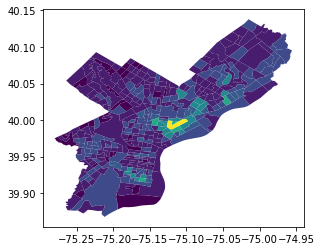

In [12]:
# seeing how the values look as a map
tracts_merged.plot(column='IndoorsMax')

In [13]:
# creating a geojson file as geopandas can't export a kml
tracts_merged.to_file("tracts_with_data.geojson", driver='GeoJSON')

In [14]:
# running the ogr2ogr process from the gdal library to convert geojson to kml
# this kml file produced doesn't actually assign the colors to each tract.
# the color needs to be assigned in the styling of each shape, which
# will need to be manipulated from the kml file
subprocess.call(r"ogr2ogr -f KML tracts_without_colors_assigned.kml tracts_with_data.geojson",shell=True)

0

In [15]:
# I got very confused by this xml namespace stuff
# Later on when I write out the final kml file, this was
# necessary to have it able to be imported by google maps
ET.register_namespace('', 'http://www.opengis.net/kml/2.2')

In [16]:
# reading the kml file
kml = ET.parse('tracts_without_colors_assigned.kml')

In [17]:
# root of the xml structure read
root = kml.getroot()
root

<Element '{http://www.opengis.net/kml/2.2}kml' at 0x0000021679515548>

In [18]:
# looking how the beginning of the structure seems
for child in root:
    print(child.tag, '    ', child.attrib)
    for subchild in child:
        print(subchild.tag, '  ', subchild.attrib)

{http://www.opengis.net/kml/2.2}Document      {'id': 'root_doc'}
{http://www.opengis.net/kml/2.2}Schema    {'name': 'tracts_with_data', 'id': 'tracts_with_data'}
{http://www.opengis.net/kml/2.2}Folder    {}


In [19]:
# there is probably a way to avoid using this prefix everywhere and use namespace correctly
# the find function is a big part of ElementTree to navigate the xml
prefix = '{http://www.opengis.net/kml/2.2}'
folder = root.find(prefix + 'Document').find(prefix + 'Folder')
folder.getchildren()

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  """


[<Element '{http://www.opengis.net/kml/2.2}name' at 0x0000021679503EF8>,
 <Element '{http://www.opengis.net/kml/2.2}Placemark' at 0x0000021679503098>,
 <Element '{http://www.opengis.net/kml/2.2}Placemark' at 0x000002167951AD68>,
 <Element '{http://www.opengis.net/kml/2.2}Placemark' at 0x000002167950ED18>,
 <Element '{http://www.opengis.net/kml/2.2}Placemark' at 0x00000216794A2C28>,
 <Element '{http://www.opengis.net/kml/2.2}Placemark' at 0x00000216794A3A48>,
 <Element '{http://www.opengis.net/kml/2.2}Placemark' at 0x0000021679523368>,
 <Element '{http://www.opengis.net/kml/2.2}Placemark' at 0x0000021679529C28>,
 <Element '{http://www.opengis.net/kml/2.2}Placemark' at 0x000002167952C6D8>,
 <Element '{http://www.opengis.net/kml/2.2}Placemark' at 0x000002167952FA98>,
 <Element '{http://www.opengis.net/kml/2.2}Placemark' at 0x0000021679550728>,
 <Element '{http://www.opengis.net/kml/2.2}Placemark' at 0x00000216795484F8>,
 <Element '{http://www.opengis.net/kml/2.2}Placemark' at 0x0000021679

In [20]:
# list of all of the tracts
tracts = folder.findall(prefix + 'Placemark')
tracts

[<Element '{http://www.opengis.net/kml/2.2}Placemark' at 0x0000021679503098>,
 <Element '{http://www.opengis.net/kml/2.2}Placemark' at 0x000002167951AD68>,
 <Element '{http://www.opengis.net/kml/2.2}Placemark' at 0x000002167950ED18>,
 <Element '{http://www.opengis.net/kml/2.2}Placemark' at 0x00000216794A2C28>,
 <Element '{http://www.opengis.net/kml/2.2}Placemark' at 0x00000216794A3A48>,
 <Element '{http://www.opengis.net/kml/2.2}Placemark' at 0x0000021679523368>,
 <Element '{http://www.opengis.net/kml/2.2}Placemark' at 0x0000021679529C28>,
 <Element '{http://www.opengis.net/kml/2.2}Placemark' at 0x000002167952C6D8>,
 <Element '{http://www.opengis.net/kml/2.2}Placemark' at 0x000002167952FA98>,
 <Element '{http://www.opengis.net/kml/2.2}Placemark' at 0x0000021679550728>,
 <Element '{http://www.opengis.net/kml/2.2}Placemark' at 0x00000216795484F8>,
 <Element '{http://www.opengis.net/kml/2.2}Placemark' at 0x0000021679546098>,
 <Element '{http://www.opengis.net/kml/2.2}Placemark' at 0x00000

In [21]:
# taking a look at where the color value is set in each tract
test = tracts[10].find(prefix + 'ExtendedData//' + prefix + 'SchemaData')
test.find('.//' + prefix + 'SimpleData[@name="color"]').text

'7ffcc2ab'

In [22]:
# going through the list of tracts to find the color value, set it and
# also set the name and description of each tract
for tract in tracts:
    # finding the values of the color, tract name, and min and max OD value
    tract_SchemaData = tract.find(prefix + 'ExtendedData//' + prefix + 'SchemaData')
    color_value = tract_SchemaData.find('.//' + prefix + 'SimpleData[@name="color"]').text
    tract_num = tract_SchemaData.find('.//' + prefix + 'SimpleData[@name="NAME10"]').text
    indoors_max = tract_SchemaData.find('.//' + prefix + 'SimpleData[@name="IndoorsMax"]').text
    indoors_min = tract_SchemaData.find('.//' + prefix + 'SimpleData[@name="IndoorsMin"]').text
    
    # I will be repeatedly created an element with it's key and then after setting the value
    # creating and setting tract name
    tract_name = ET.SubElement(tract, 'name')
    tract_name.text = 'Census Tract ' + tract_num
    # creating and setting the description to easily see the min and max for each tract
    tract_desc = ET.SubElement(tract, 'description')
    tract_desc.text = 'Indoors Min-Max OD Fatalities: ' + indoors_min + '-' + indoors_max
    # going to the styling element
    polystyle = tract.find(prefix + 'Style//' + prefix + 'PolyStyle')
    # I believe the fill value is needed to fill the whole polygon with the color set
    polystyle.find('.//' + prefix + 'fill' ).text = '1'
    # creating and setting the color value
    color_tag = ET.SubElement(polystyle, 'color')
    color_tag.text = color_value

In [23]:
kml.write('tracts_with_colors.kml', xml_declaration=True, encoding='utf-8')